In [1]:
import pandas as pd
import numpy as np

In [5]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [3]:
drive_path = ''#"/content/drive/MyDrive/DS Shared/FMA/"
data = pd.read_excel(drive_path + 'Euro.xlsx', header=None)

In [4]:
# Function to match a given string
def match_string(x, string):
    if pd.isna(x):
        return False
    else:
        return string in x

# Function to get the factor df for all equities
def get_factor_df(factor, perfect_match=False):
    if perfect_match:
        price_book = data[0].apply(lambda x: x == factor)
    else:
        price_book = data[0].apply(match_string, args={factor})
    df = data[price_book].set_index(equities)
    df.drop(0, axis=1, inplace=True)
    df.columns = dates[1:]

    return df

In [5]:
# Get all equities
equities = data[0].apply(match_string, args={'Equity'})
equities = data.loc[equities][0]

# Get all factors
factors = [i for i in data[0].unique() if i not in equities.values][1:-1]

# Get all dates
dates = data.iloc[1]

## Table of returns

In [6]:
# Compute log returns for all equities
prices = get_factor_df('PX_LAST').T # get prices
log_returns = np.log(prices.pct_change() + 1) # compute log returns

/opt/anaconda3/envs/OpenCV/lib/python3.8/site-packages/pandas/core/internals/blocks.py:402: RuntimeWarning: divide by zero encountered in log
  result = func(self.values, **kwargs)


In [7]:
# Function that compute the aggregate log returns for a df containing the returns of mulitple stocks
def get_returns(df):
    returns = []
    for mth in df.columns:

        mth = mth.strftime('%Y-%m-%d')

        zero_mask = df[mth].apply(lambda x: (x != 0) and (not pd.isna(x)) and (np.abs(x) != np.inf))

        returns.append(df[mth].loc[zero_mask].mean())

    return pd.Series(returns, index=dates[1:])

In [8]:
# Compute the benchmark returns
bch = get_returns(log_returns.T)

In [9]:
bch.to_csv(drive_path + 'returns/' + 'bch.csv')

In [10]:
import matplotlib.pyplot as plt

def plot_performance(log_rets):
    fig, ax = plt.subplots(1,2, figsize=(12,5))

    for log_ret in log_rets:
        log_ret.plot(ax=ax[0])

        ret = np.exp(log_ret)
        eqty_line = 100 * np.cumprod(ret)
        eqty_line.plot(ax=ax[1])

        ax[0].set_title('Log Returns')
        ax[1].set_title('Equity Line')


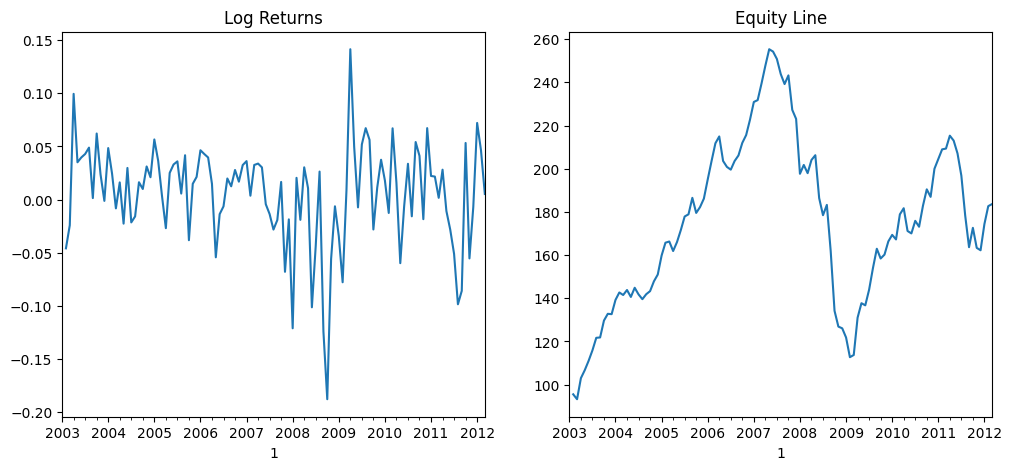

In [11]:
plot_performance([bch])

## Univariate Screening

In [12]:
# Get P/B df
price_book = get_factor_df('PX_TO_BOOK_RATIO')

In [13]:
# Shift the P/B to account for lag of fundamental information
price_book = price_book.T.shift(3).T

In [14]:
# Fuction to compute the share of stocks that changes between periods
def get_turnover(prec, actual, ptf_size):
    k = 0
    for i in prec: # prec is the previous period portfolio
        if i not in actual: # actual is the current period portfolio
            k += 1

    return k / ptf_size # ptf_size is the size of the long/short portfolio

In [15]:
# Function to compute univariate screening returns for a factor df
def univariate_screening(df, sign, how='both', ptf_size = 50, trans_cost = 0.002, holding_period=1):
    # Check available methods
    if how not in ('long', 'short', 'both'):
        print('Mehtod not allowed!')
        return None

    long_returns = []
    short_returns = []

    to_long = []
    to_short = []

    long_temp = []
    short_temp = []

    hist_long = []
    hist_short = []
    hist_turnover = []

    if how == 'both':
        ptf_size = ptf_size // 2 # with 'both' method, ptf size is split in long and short positions

    # Compute retuns for every month
    for i, mth in enumerate(df.columns[:-1]):

        if i % holding_period == 0:
            zero_mask = df[mth] != 0 # filter non-zero stocks for the factor

            ordered_pb = (df.loc[zero_mask, mth].dropna() * sign).sort_values(ascending=False) # order stock depending on the factor
            # set 'sign' 1 to go long on the higher values and short on lower values
            # set 'sign' -1 to go short on the higher values and long on lower values

            if how == 'both':
                to_long = ordered_pb[:ptf_size].index # stock to go long
                to_short = ordered_pb[-ptf_size:].index # stock to go long
            elif how == 'long':
                to_long = ordered_pb[:ptf_size].index # stock to go long
            else:
                to_short = ordered_pb[-ptf_size:].index # stock to go long

        hist_long.append(to_long)
        hist_short.append(to_short)

        # Compute returns
        long_return = get_returns(log_returns.T.loc[to_long])[df.columns[i+1]]
        short_return = - get_returns(log_returns.T.loc[to_short])[df.columns[i+1]] # computed by inverting the sign of regular returns

        # Transaction costs
        long_turnover = get_turnover(to_long, long_temp, ptf_size)
        short_turnover = get_turnover(to_short, short_temp, ptf_size)

        long_fee = trans_cost * long_turnover
        short_fee = trans_cost * short_turnover

        long_temp = to_long
        short_temp = to_short

        long_returns.append(long_return - long_fee)
        short_returns.append(short_return - short_fee)

    long_returns = pd.Series(long_returns, index=df.columns[1:])
    short_returns = pd.Series(short_returns, index=df.columns[1:])

    # Compute overall returns
    univ_returns = pd.concat([long_returns, short_returns], axis=1)
    univ_returns.columns = ['Long', 'Short']
    univ_returns['Overall'] = (univ_returns['Long'] + univ_returns['Short']) / 2

    if how == 'long':
        final_returns = long_returns
    elif how == 'short':
        final_returns = short_returns
    else:
        final_returns = univ_returns['Overall']

    return final_returns, hist_long, hist_short

In [37]:
# Apply univariate screening for P/B
univ_returns, hlong, hshort = univariate_screening(price_book, -1, how='long')

In [38]:
univ_returns.to_csv(drive_path + 'returns/' + 'univ.csv')

In [16]:
import seaborn as sns
import matplotlib.dates as mdates

def plot_positions(df, hlong, hshort):
    long_df = []
    short_df = []

    for i, j in zip(hlong, hshort):
        long_df.append(pd.Series(df.index).apply(lambda x: x in i))
        short_df.append(pd.Series(df.index).apply(lambda x: x in j))

    long_df = pd.concat(long_df, axis=1)
    long_df.index = df.index
    long_df.columns = pd.Series(df.columns[1:]).apply(lambda x: x.strftime('%m-%Y')).values

    short_df = pd.concat(short_df, axis=1)
    short_df.index = df.index
    short_df.columns = pd.Series(df.columns[1:]).apply(lambda x: x.strftime('%m-%Y')).values

    fig, ax = plt.subplots(1, 2, figsize=(14,4))

    sns.heatmap(long_df, cmap='hot', ax=ax[0])
    sns.heatmap(short_df, cmap='hot', ax=ax[1])

    ax[0].set_title('Long positions')
    ax[1].set_title('Short positions')

    ax[0].collections[0].colorbar.remove()
    ax[0].set_ylabel('')
    ax[0].set_yticks([])
    ax[0].set_yticklabels([])

    ax[1].collections[0].colorbar.remove()
    ax[1].set_ylabel('')
    ax[1].set_yticks([])
    ax[1].set_yticklabels([])

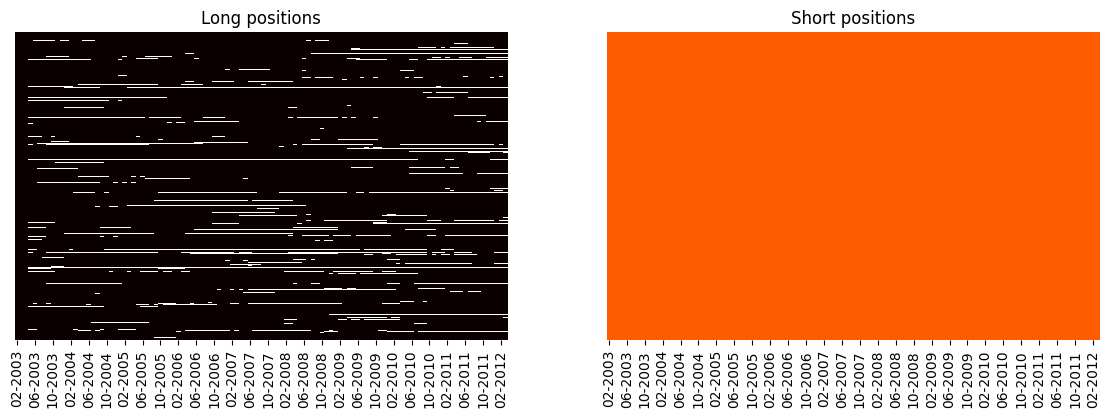

In [40]:
plot_positions(price_book, hlong, hshort)

### Performances

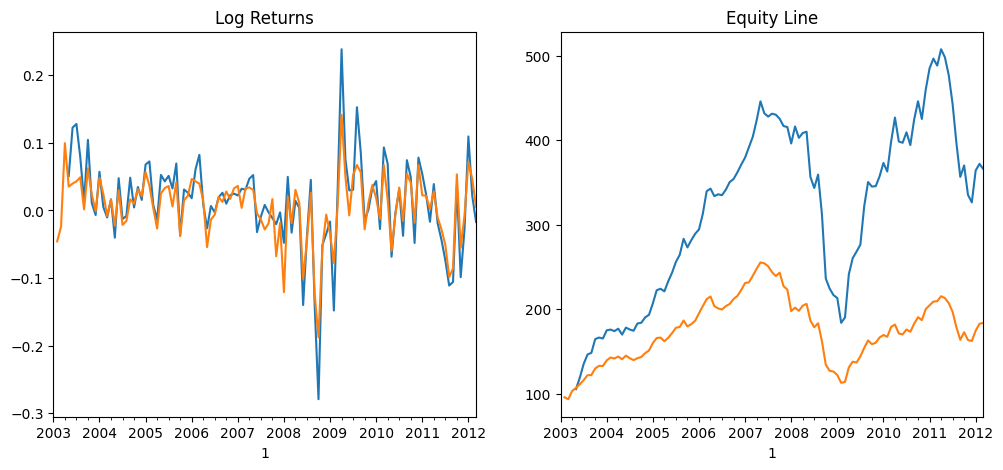

In [41]:
# Plot returns
plot_performance([univ_returns, bch])

In [17]:
# Information Ratio
def get_IR(strat, bchmk):
    alpha = strat - bchmk
    return np.round(np.mean(alpha) / np.std(alpha) * np.sqrt(12), 3) # compute mean annual IR

In [18]:
get_IR(univ_returns.iloc[3:], bch.iloc[4:])

NameError: name 'univ_returns' is not defined

In [19]:
# Compute absolute metrics
def get_metrics(strat, bchmk, rf=0.03):

    rf = np.log((1 + rf) ** (1 / 12))

    # Sharpe
    sharpe = strat - rf
    sharpe = np.mean(sharpe) / np.std(sharpe) * np.sqrt(12)

    # Traynor
    traynor = strat - rf
    traynor = np.mean(traynor) / (np.cov(strat, bchmk)[0][1] / np.var(bchmk)) * 12

    # Sorbino
    Sortino = strat - rf
    under_mean = Sortino[Sortino <= np.mean(Sortino)]
    Sortino = np.mean(Sortino) / np.std(under_mean) * np.sqrt(12)

    return {
        'Sharpe': np.round(sharpe, 3),
        'Traynor': np.round(traynor, 3),
        'Sortino': np.round(Sortino, 3)}

In [20]:
get_metrics(univ_returns.iloc[3:], bch.iloc[4:])

NameError: name 'univ_returns' is not defined

In [21]:
def univ_holding_cv(df,  max_n, sign, how='both', ptf_size=50):
    IRs = []
    for i in range(max_n):
        ret, _, _ = univariate_screening(df, sign, how=how, ptf_size=ptf_size, holding_period=i+1)
        IR = get_IR(ret.iloc[3:], bch.iloc[3:])
        IRs.append(IR)
        print(f'Holding period: {i+1} -- IR: {IR}')

    return pd.Series(IRs)

Holding period: 1 -- IR: 1.216
Holding period: 2 -- IR: 1.373
Holding period: 3 -- IR: 1.442
Holding period: 4 -- IR: 1.245
Holding period: 5 -- IR: 1.353
Holding period: 6 -- IR: 1.258


<Axes: >

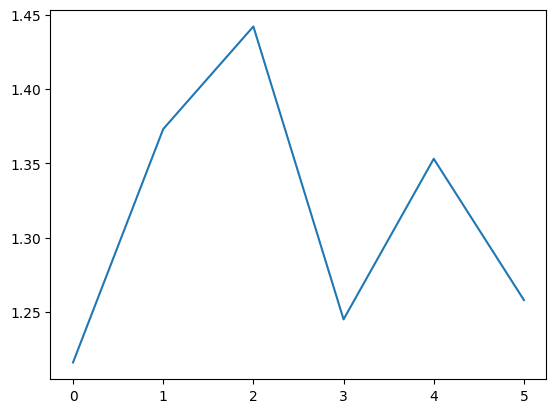

In [290]:
univ_holding_cv(price_book.iloc[:, :int(111*0.8)], 6, -1, how='long').plot()

## Multivariate screening

### Lakonishock

**Lakonishok strategy**
Aziende out of favor, top 30% capitalizzazione (NYSE), fra cui si selezionano le più sottovalutate, P/E e P/B sotto la media di settore. Infine con Delta consensus in crescita e RSI che si inverte, per individuare titoli la cui tendenza di depressione si sia invertita.

Factors:

* CAP $\rightarrow$ CUR_MKT_CAP
* P/B $\rightarrow$ PX_TO_BOOK_RATIO
* P/E $\rightarrow$ PE_RATIO
* RSI $\rightarrow$ RSI_30D
* CONS $\rightarrow$ EQY_REC_CONS

In [22]:
# Get top 30% capitalisation
CAP = get_factor_df('CUR_MKT_CAP', perfect_match=True)

ptf_size = int(0.3 * len(CAP))
top30 = []

for mth in CAP.columns:
    ordered_pb = (CAP[mth]).sort_values(ascending=False)

    top30.append(list(ordered_pb[:ptf_size].index))

In [23]:
# top30 is a list of lists of top 30% capitalisation stocks for each period
top30[0][:5]

['FP FP Equity',
 'NOK1V FH Equity',
 'ENI IM Equity',
 'DTE GR Equity',
 'TEF SM Equity']

In [25]:
# Function to compute Lakonishock screening
def lakonishock_screening(df, equities, sign, ptf_size = 50, trans_cost = 0.002, holding_period=1):

    returns = []
    temp = []

    for (i, mth), eqy in zip(enumerate(df.columns[:-1]), equities):

        if i % holding_period == 0:
            mth_df = df.loc[eqy, mth] # monthly factor series filtered for selected stocks

            zero_mask = mth_df != 0 # filter non-zero stocks

            ordered_pb = (mth_df.loc[zero_mask].dropna() * sign).sort_values(ascending=False)

            to_long = ordered_pb[-ptf_size:].index

        # Compute returns
        ret = get_returns(log_returns.T.loc[to_long])[df.columns[i+1]]

        # Transaction costs
        long_fee = trans_cost * get_turnover(to_long, temp, ptf_size)

        temp = to_long

        returns.append(ret - long_fee)

    returns = pd.Series(returns, index=df.columns[1:])

    return returns

In [26]:
PB = get_factor_df('PX_TO_BOOK_RATIO', perfect_match=True)
PE = get_factor_df('PE_RATIO', perfect_match=True)
RSI = get_factor_df('RSI_30D', perfect_match=True)
CON = get_factor_df('EQY_REC_CONS', perfect_match=True)

In [27]:
# Lagging
PB = PB.T.shift(3, fill_value=np.nan).T
PE = PE.T.shift(3, fill_value=np.nan).T
CON = CON.T.shift(3, fill_value=np.nan).T

In [28]:
# Delta consensus
dCON = CON.T.diff(3).T

In [29]:
# Lakonishock screening screening
PB_screen = lakonishock_screening(PB, top30, 1)
PE_screen = lakonishock_screening(PE, top30, 1)
RSI_screen = lakonishock_screening(RSI, top30, 1)
dCON_screen = lakonishock_screening(dCON, top30, -1)

In [30]:
# Standardize function
# we assume zero and nan observations to be irrelevant for the calculations
def standardize(x):
    y = x[x != 0].dropna() # filter nan and non-zero entities to compute mean and std
    if np.std(y) == 0:
        return np.repeat(np.nan, len(x))
    else:
        return np.where(x != 0, (x - np.mean(y)) / np.std(y), 0)

In [31]:
PBz = PB.apply(standardize)
PEz = PE.apply(standardize)
RSIz = RSI.apply(standardize)
dCONz = dCON.apply(standardize)

In [44]:
weights = {
    'PB': [],
    'PE': [],
    'RSI': [],
    'dCON': []
}

Zscores = []

for i, mth in enumerate(PB.columns):
    # Get the IR for each univariate screening
    PB_IR = get_IR(PB_screen.loc[:mth], bch.loc[:mth])
    PE_IR = get_IR(PE_screen.loc[:mth], bch.loc[:mth])
    RSI_IR = get_IR(RSI_screen.loc[:mth], bch.loc[:mth])
    dCON_IR = get_IR(dCON_screen.loc[:mth], bch.loc[:mth])

    TOT_IR = np.sum(np.abs((PB_IR, PE_IR, RSI_IR, dCON_IR)))
    sign = np.sign(np.sum((PB_IR, PE_IR, RSI_IR, dCON_IR)))

    weights['PB'].append(PB_IR / TOT_IR * sign)
    weights['PE'].append(PE_IR / TOT_IR * sign)
    weights['RSI'].append(RSI_IR / TOT_IR * sign)
    weights['dCON'].append(dCON_IR / TOT_IR * sign)

    Zsc = (PBz.loc[:, mth] * PB_IR + PEz.loc[:, mth] * PE_IR + RSIz.loc[:, mth] * RSI_IR - dCONz.loc[:, mth] * dCON_IR) / TOT_IR * sign
    Zscores.append(Zsc)

Zscores = pd.concat(Zscores, axis=1)
weights = pd.DataFrame(weights)

weights.index = Zscores.columns

/var/folders/58/mbdv_l695f5dn7zb8sb9x6h80000gn/T/ipykernel_42846/3772480622.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return np.round(np.mean(alpha) / np.std(alpha) * np.sqrt(12), 3) # compute mean annual IR
/var/folders/58/mbdv_l695f5dn7zb8sb9x6h80000gn/T/ipykernel_42846/3772480622.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return np.round(np.mean(alpha) / np.std(alpha) * np.sqrt(12), 3) # compute mean annual IR
/var/folders/58/mbdv_l695f5dn7zb8sb9x6h80000gn/T/ipykernel_42846/3772480622.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return np.round(np.mean(alpha) / np.std(alpha) * np.sqrt(12), 3) # compute mean annual IR
/var/folders/58/mbdv_l695f5dn7zb8sb9x6h80000gn/T/ipykernel_42846/3772480622.py:4: RuntimeWarning: divide by zero encountered in double_scalars
  return np.round(np.mean(alpha) / np.std(alpha) * np.sqrt(12), 3) # compute mean annual IR
/var/folders/58/mbdv_l695f5dn7zb8sb9x6h80000gn/T/ipykernel_4

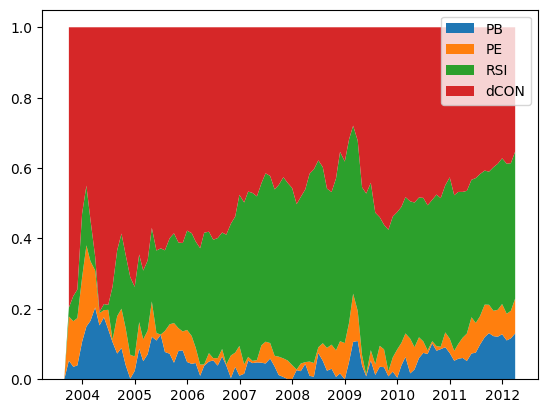

In [45]:
plt.stackplot(Zscores.columns, np.abs(weights).values.T, labels=weights.columns)
plt.legend()

In [38]:
weights.dropna().to_csv(drive_path + 'returns/' + 'weights.csv')

In [46]:
# Compute the score of each factor
(PB_IR, PE_IR, RSI_IR, dCON_IR) / np.sum((PB_IR, PE_IR, RSI_IR, dCON_IR))

array([0.13041126, 0.09902597, 0.41774892, 0.35281385])

In [47]:
# Univariate screening on the aggregate score taking only long positions
multiv_returns, hlong, hshort = univariate_screening(Zscores, 1, how='long')

In [41]:
multiv_returns.to_csv(drive_path + 'returns/' + 'multiv.csv')

In [49]:
MVT_IR = get_IR(multiv_returns.iloc[8:], bch.iloc[9:])
MVT_IR

0.127

In [43]:
get_metrics(multiv_returns.iloc[8:], bch.iloc[9:])

{'Sharpe': 0.186, 'Traynor': 0.034, 'Sortino': 0.227}

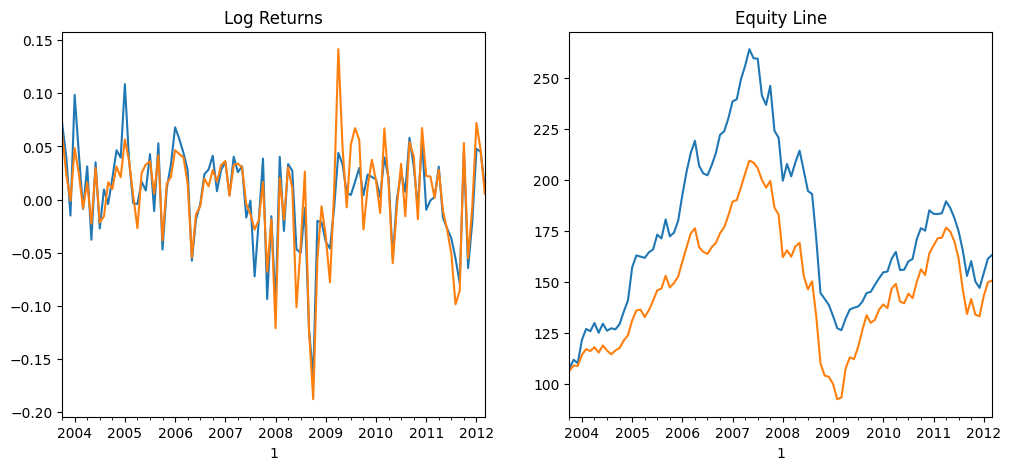

In [44]:
plot_performance([multiv_returns[8:], bch[9:]])

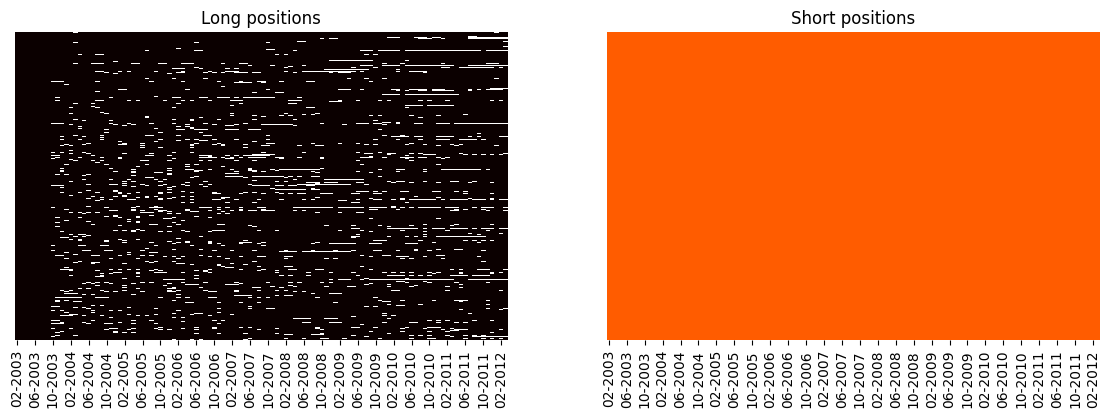

In [45]:
plot_positions(Zscores, hlong, hshort)

Holding period: 1 -- IR: 0.191
Holding period: 2 -- IR: -0.014
Holding period: 3 -- IR: 0.074
Holding period: 4 -- IR: -0.235
Holding period: 5 -- IR: -0.356
Holding period: 6 -- IR: -0.21


<Axes: >

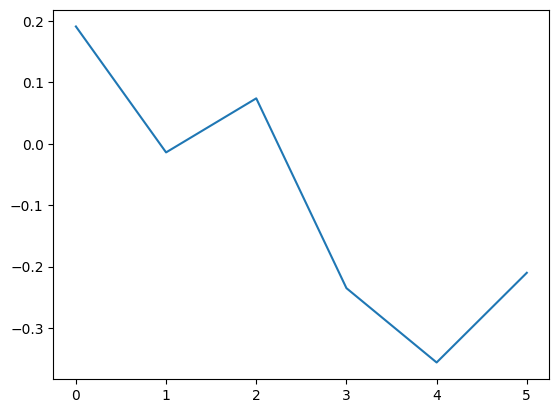

In [46]:
univ_holding_cv(Zscores.iloc[:, :int(111*0.8)], 6, 1, ptf_size=50, how='long').plot()

### Sequential

In [55]:
# Function to compute sequential screening
def sequential_screening(dfs, signs, how='both', eqty_start=500, eqty_end=50, trans_cost = 0.002, holding_period=1):
    if how not in ('long', 'short', 'both'):
        print('Mehtod not allowed!')
        return None

    long_returns = []
    short_returns = []

    # Compute the number of stocks to take at each sequential step
    step = (eqty_start - eqty_end) // len(dfs)
    sizes = [eqty_start - (i+1) * step for i in range(len(dfs) - 1)]
    sizes.append(eqty_end)

    to_long = []
    to_short = []

    long_temp = []
    short_temp = []

    hist_long = []
    hist_short = []

    for i, mth in enumerate(dfs[0].columns[:-1]):
        # at the beginnning to_long and to_short contain all the stocks
        if how == 'both':
            to_long = list(dfs[0].index)
            to_short = list(dfs[0].index)
        elif how == 'long':
            to_long = list(dfs[0].index)
        else:
            to_short = list(dfs[0].index)

        if i % holding_period == 0:
            # sequential screening
            for df, ptf_size, sign in zip(dfs, sizes, signs):

                all_eqty = list(to_short) + [i for i in to_long if i not in to_short] # equities to be considered at each step

                if how == 'both':
                    ptf_size = ptf_size // 2

                zero_mask = df.loc[all_eqty, mth] != 0 # filter non-zero stocks

                ordered_pb = (df.loc[zero_mask.index].loc[zero_mask, mth].dropna() * sign).sort_values(ascending=False)

                if how == 'both':
                  to_long = ordered_pb[:ptf_size].index # stock to go long
                  to_short = ordered_pb[-ptf_size:].index # stock to go long
                elif how == 'long':
                  to_long = ordered_pb[:ptf_size].index # stock to go long
                else:
                  to_short = ordered_pb[-ptf_size:].index # stock to go long

        hist_long.append(to_long)
        hist_short.append(to_short)

        # Compute returns
        long_return = get_returns(log_returns.T.loc[to_long])[df.columns[i+1]]
        short_return = - get_returns(log_returns.T.loc[to_short])[df.columns[i+1]] # i ritorni short vanno invertiti di segno!

        # Transaction costs
        long_fee = trans_cost * get_turnover(to_long, long_temp, ptf_size)
        short_fee = trans_cost * get_turnover(to_short, short_temp, ptf_size)

        long_temp = to_long
        short_temp = to_short

        long_returns.append(long_return - long_fee)
        short_returns.append(short_return - short_fee)

    long_returns = pd.Series(long_returns, index=dfs[0].columns[1:])
    short_returns = pd.Series(short_returns, index=dfs[0].columns[1:])

    univ_returns = pd.concat([long_returns, short_returns], axis=1)
    univ_returns.columns = ['Long', 'Short']
    univ_returns['Overall'] = (univ_returns['Long'] + univ_returns['Short']) / 2

    if how == 'long':
        final_returns = long_returns
    elif how == 'short':
        final_returns = short_returns
    else:
        final_returns = univ_returns['Overall']

    return final_returns, hist_long, hist_short

In [56]:
# Compute sequential screening
seq_returns, hlong, hshort = sequential_screening([CAP, RSI, dCON, PB, PE], [1, -1, 1, -1, -1], how='long')

In [57]:
seq_returns.to_csv(drive_path + 'returns/' + 'seq.csv')

In [58]:
get_IR(seq_returns.iloc[6:], bch.iloc[7:])

-0.727

In [59]:
get_metrics(seq_returns.iloc[6:], bch.iloc[7:])

{'Sharpe': -0.109, 'Traynor': -0.018, 'Sortino': -0.127}

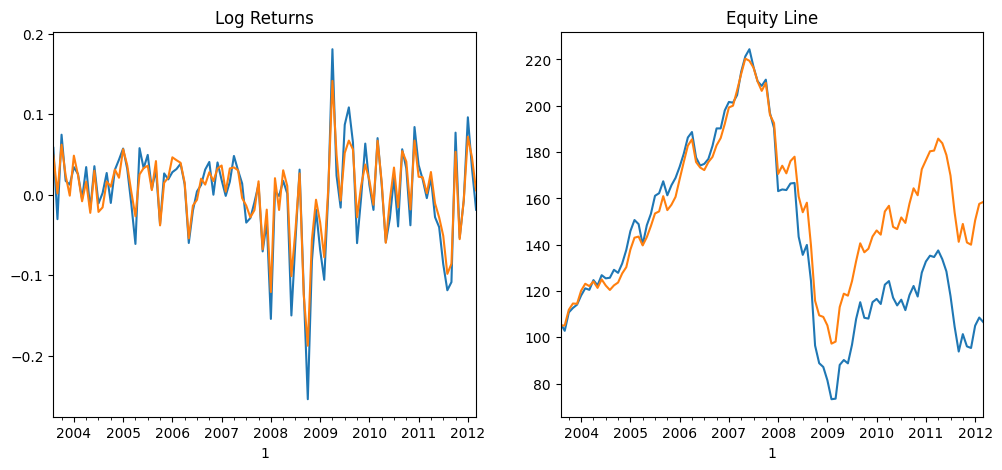

In [60]:
plot_performance([seq_returns[6:], bch[7:]])

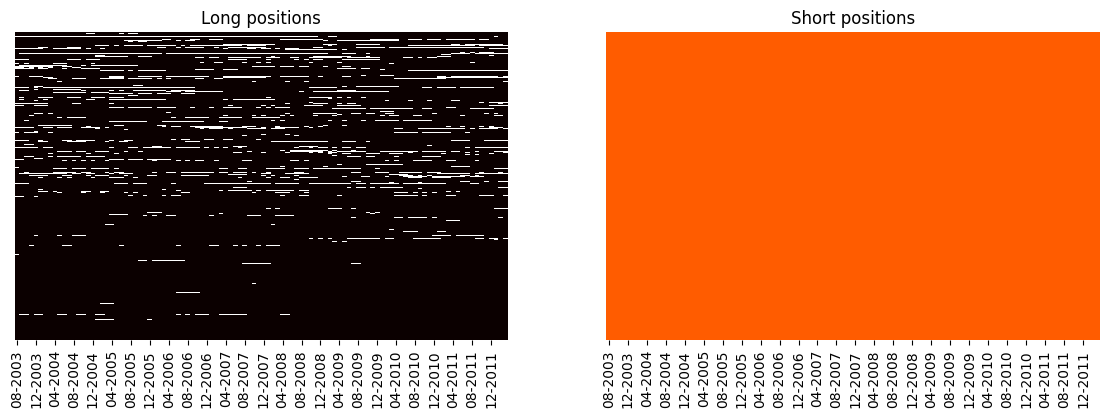

In [61]:
plot_positions(PB.iloc[:, 6:], hlong[6:], hshort[6:])

In [62]:
def seq_holding_cv(dfs, max_n, signs, how='both', eqty_start=500, eqty_end=50):
    IRs = []
    for i in range(max_n):
        ret, _, _ = sequential_screening(dfs, signs, how=how, eqty_start=eqty_start, eqty_end=eqty_end, holding_period=i+1)
        IR = get_IR(ret.iloc[3:], bch.iloc[3:])
        IRs.append(IR)
        print(f'Holding period: {i+1} -- IR: {IR}')

    return pd.Series(IRs)

Holding period: 1 -- IR: -0.727
Holding period: 2 -- IR: -2.901
Holding period: 3 -- IR: -2.499
Holding period: 4 -- IR: -2.174
Holding period: 5 -- IR: -1.911
Holding period: 6 -- IR: -1.499


<Axes: >

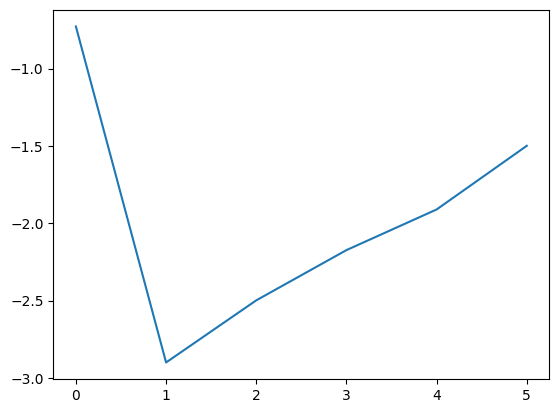

In [63]:
seq_holding_cv([CAP, RSI, dCON, PB, PE], 6, [1, -1, 1, -1, -1], how='long', eqty_start=500, eqty_end=50).plot()

### PCA

In [67]:
from sklearn.decomposition import PCA

pca_df = []

pca = PCA(n_components=1)

for i in dates[1:]:
    dfs = []
    for df in (PBz, PEz, RSIz, dCONz):
        dfs.append(df.loc[:, i])

    dfs = pd.concat(dfs, axis=1)
    scores = pca.fit_transform(dfs.fillna(0)) # compute PCA score
    pca_df.append(pd.Series(scores.ravel()))

pca_df = pd.concat(pca_df, axis=1)
pca_df.index = df.index
pca_df.columns = dates[1:]

In [68]:
# Univariate screening on PCA scores
pca_returns, hlong, hshort = univariate_screening(pca_df, 1, how='long', ptf_size=50)

In [69]:
pca_returns.to_csv(drive_path + 'returns/' + 'pca.csv')

In [70]:
get_IR(pca_returns.iloc[5:], bch.iloc[6:])

0.051

In [71]:
get_metrics(pca_returns.iloc[5:], bch.iloc[6:])

{'Sharpe': 0.204, 'Traynor': 0.039, 'Sortino': 0.289}

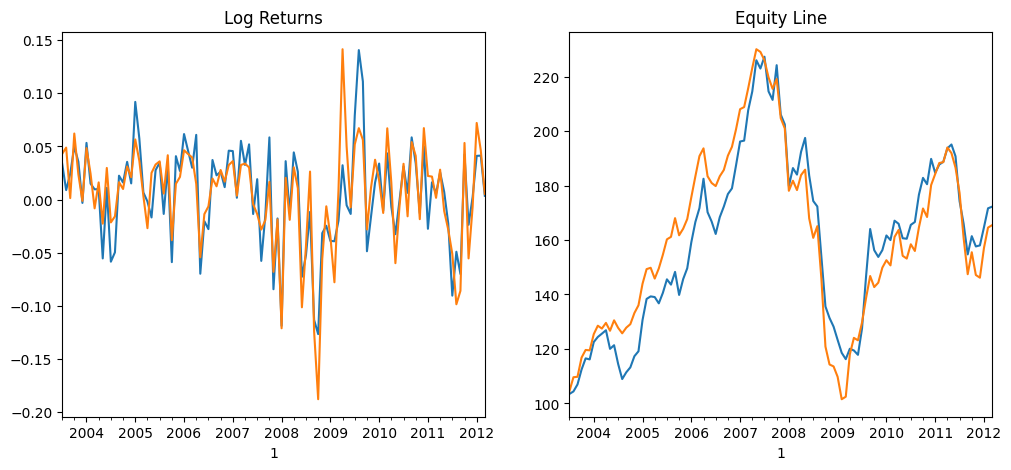

In [72]:
plot_performance([pca_returns[5:], bch[6:]])

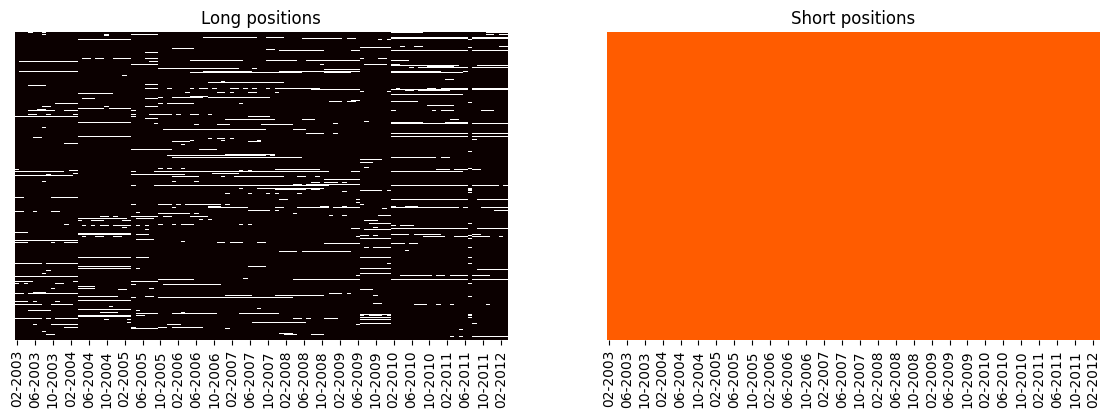

In [73]:
plot_positions(pca_df, hlong, hshort)

Holding period: 1 -- IR: 0.001
Holding period: 2 -- IR: -0.08
Holding period: 3 -- IR: -0.438
Holding period: 4 -- IR: -0.432
Holding period: 5 -- IR: -0.727
Holding period: 6 -- IR: -0.204


<Axes: >

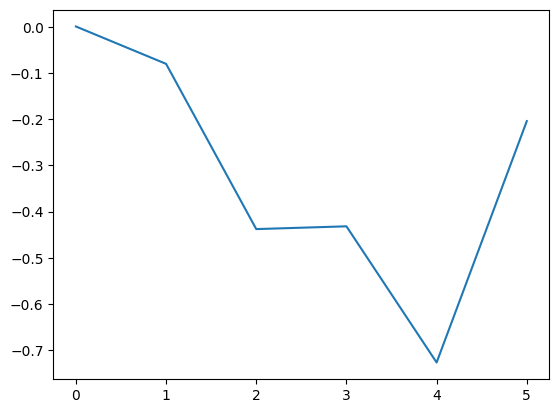

In [74]:
univ_holding_cv(pca_df.iloc[:, :int(111*0.8)], 6, 1, how='long', ptf_size=50).plot()

## Deep Learning

In [ ]:
from tensorflow import keras
import tensorflow as tf

### Data import and preprocessing

In [214]:
# Interpolate returns to remove nans and inf/-inf observations
pure_ret = log_returns[1:].interpolate().T.dropna().T
pure_ret = pure_ret.replace([np.inf, -np.inf], 0)

### Training, validation, and test split

In [215]:
df = pure_ret

size = len(df)
train = [] # 80% of data
valid = [] # 10% of data
test = [] # 10% of data

for i, col in enumerate(df.columns):
  a = []
  b = []
  c = []
  for j in range(13): # create training instances by shifting data from t to t-12
    a.append(df.shift(j).iloc[:int(size*0.8), i])
    b.append(df.shift(j).iloc[int(size*0.8):int(size*0.9), i])
    c.append(df.shift(j).iloc[int(size*0.9):, i])

  train.append(pd.concat(a, axis=1).reset_index(drop=True).dropna())
  valid.append(pd.concat(b, axis=1).reset_index(drop=True).dropna())
  test.append(pd.concat(c, axis=1).reset_index(drop=True).dropna())

In [216]:
a = train[0].values
for i in train[1:]:
  a = np.r_[a, i.values]

b = valid[0].values
for i in valid[1:]:
  b = np.r_[b, i.values]

c = test[0].values
for i in test[1:]:
  c = np.r_[c, i.values]

In [217]:
X_train = a[:, 1:]
y_train = a[:, 0]
y_train =  np.c_[np.where(y_train >= 0, 1, 0), np.where(y_train < 0, 1, 0)]

X_valid = b[:, 1:]
y_valid = b[:, 0]
y_valid =  np.c_[np.where(y_valid >= 0, 1, 0), np.where(y_valid < 0, 1, 0)]

X_test = c[:, 1:]
y_test = c[:, 0]
y_test = np.c_[np.where(y_test >= 0, 1, 0), np.where(y_test < 0, 1, 0)]

### Modeling

In [220]:
import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import LSTM, Dense, Input, concatenate

input = Input(shape=(12, 1))

# Define LSTM layers for each input
x = LSTM(40, return_sequences=True)(input)
x = LSTM(40, return_sequences=True)(x)
x = LSTM(8)(x)
output = Dense(2, activation='softmax')(x)

model = Model(inputs=input, outputs=output)

# Compile the model with custom loss
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=[keras.metrics.BinaryAccuracy()])

# Print the model summary
model.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 12, 1)]           0         
                                                                 
 lstm_3 (LSTM)               (None, 12, 40)            6720      
                                                                 
 lstm_4 (LSTM)               (None, 12, 40)            12960     
                                                                 
 lstm_5 (LSTM)               (None, 8)                 1568      
                                                                 
 dense_1 (Dense)             (None, 2)                 18        
                                                                 
Total params: 21,266
Trainable params: 21,266
Non-trainable params: 0
_________________________________________________________________


In [221]:
# Restore the weights
model.load_weights(drive_path + 'lstm.hdf5')

In [ ]:
tf.random.set_seed(42)

history = model.fit(X_train, y_train,
          batch_size=64,
          epochs=20,
          validation_data=[X_valid, y_valid])

Epoch 1/20
829/829 [==============================] - 19s 10ms/step - loss: 0.6827 - binary_accuracy: 0.5691 - val_loss: 0.6574 - val_binary_accuracy: 0.6388
Epoch 2/20
829/829 [==============================] - 7s 9ms/step - loss: 0.6798 - binary_accuracy: 0.5754 - val_loss: 0.6594 - val_binary_accuracy: 0.6289
Epoch 3/20
829/829 [==============================] - 7s 8ms/step - loss: 0.6786 - binary_accuracy: 0.5762 - val_loss: 0.6499 - val_binary_accuracy: 0.6200
Epoch 4/20
829/829 [==============================] - 7s 9ms/step - loss: 0.6756 - binary_accuracy: 0.5760 - val_loss: 0.6254 - val_binary_accuracy: 0.6090
Epoch 5/20
829/829 [==============================] - 7s 8ms/step - loss: 0.6646 - binary_accuracy: 0.5742 - val_loss: 0.6125 - val_binary_accuracy: 0.6231
Epoch 6/20
829/829 [==============================] - 9s 10ms/step - loss: 0.6601 - binary_accuracy: 0.5789 - val_loss: 0.6116 - val_binary_accuracy: 0.6237
Epoch 7/20
829/829 [==============================] - 6s 8ms/

In [ ]:
# Save the weights
model.save_weights(drive_path + 'lstm.hdf5')

In [222]:
def eval_model(X, y):
  loss, acc = model.evaluate(X, y)
  prand = y[:, 0].sum() / y.shape[0]
  prand = np.max([prand, 1-prand])
  log_base = -((np.log(prand) - np.log(1 - prand)) * prand + np.log(1-prand))

  print('MODEL \t\t ACCURACY \t LOSS')
  print(f"Random guess \t {np.round(prand, 3)} \t\t {np.round(log_base, 3)}")
  print(f'Deep Learning \t {np.round(acc, 3)} \t\t {np.round(loss, 3)}')

In [223]:
eval_model(X_train, y_train)

1658/1658 [==============================] - 15s 8ms/step - loss: 0.6431 - binary_accuracy: 0.5960
MODEL 		 ACCURACY 	 LOSS
Random guess 	 0.562 		 0.685
Deep Learning 	 0.596 		 0.643


In [224]:
eval_model(X_valid, y_valid)

240/240 [==============================] - 2s 7ms/step - loss: 0.6136 - binary_accuracy: 0.6179
MODEL 		 ACCURACY 	 LOSS
Random guess 	 0.657 		 0.643
Deep Learning 	 0.618 		 0.614


In [225]:
eval_model(X_test, y_test)

240/240 [==============================] - 2s 9ms/step - loss: 0.6295 - binary_accuracy: 0.5155
MODEL 		 ACCURACY 	 LOSS
Random guess 	 0.507 		 0.693
Deep Learning 	 0.515 		 0.629


In [226]:
y_hat = model.predict(X_train)

1658/1658 [==============================] - 13s 7ms/step


In [227]:
def get_predictions(y_hat, threshold=0):
  return np.where(y_hat[:, 0] > 0.5 + threshold, 1, np.where(y_hat[:, 0] < 0.5 - threshold, -1, 0))

In [228]:
from tqdm import tqdm

train_scores = []
for i in tqdm(train):

  X = i.values[:, :12]
  y = model.predict(X, verbose=0)

  train_scores.append(get_predictions(y, 0.2))

train_scores = pd.DataFrame(np.r_[train_scores])

test_scores = []
for i, j in tqdm(zip(valid, test)):

  X = np.r_[i.values, j.values][:, :12]
  y = model.predict(X, verbose=0)

  test_scores.append(get_predictions(y, 0.2))

test_scores = pd.DataFrame(np.r_[test_scores])

100%|██████████| 698/698 [01:17<00:00,  9.03it/s]
698it [00:56, 12.43it/s]


In [ ]:
train_scores.index = df.columns
train_scores.columns = df.iloc[12:int(size*0.8), :].index

test_scores.index = df.columns
test_scores.columns = df.iloc[int(size*0.8):, :].index

In [ ]:
dl_train_returns, train_hlong, train_hshort = univariate_screening(train_scores, 1, how='long', ptf_size=200, holding_period=1)
dl_test_returns, test_hlong, test_hshort = univariate_screening(test_scores, 1, how='long', ptf_size=200, holding_period=1)

In [ ]:
dl_train_returns.to_csv(drive_path + 'returns/' + 'train.csv')
dl_test_returns.to_csv(drive_path + 'returns/' + 'test.csv')

In [235]:
alpha = dl_train_returns.values - bch.iloc[14:int(size*0.8 + 1)].values
np.round(np.mean(alpha) / np.std(alpha) * np.sqrt(12), 3)

0.902

In [236]:
get_metrics(dl_train_returns.values, bch.iloc[14:int(size*0.8 + 1)].values)

{'Sharpe': 0.284, 'Traynor': 0.049, 'Sortino': 0.317}

In [241]:
get_IR(dl_test_returns, bch.iloc[int(size*0.8 + 1)+1:])

-0.338

In [243]:
get_metrics(dl_test_returns, bch.iloc[int(size*0.8 + 1)+1:])

{'Sharpe': -0.035, 'Traynor': -0.006, 'Sortino': -0.063}

Text(0.5, 1.0, 'Test Equity Line')

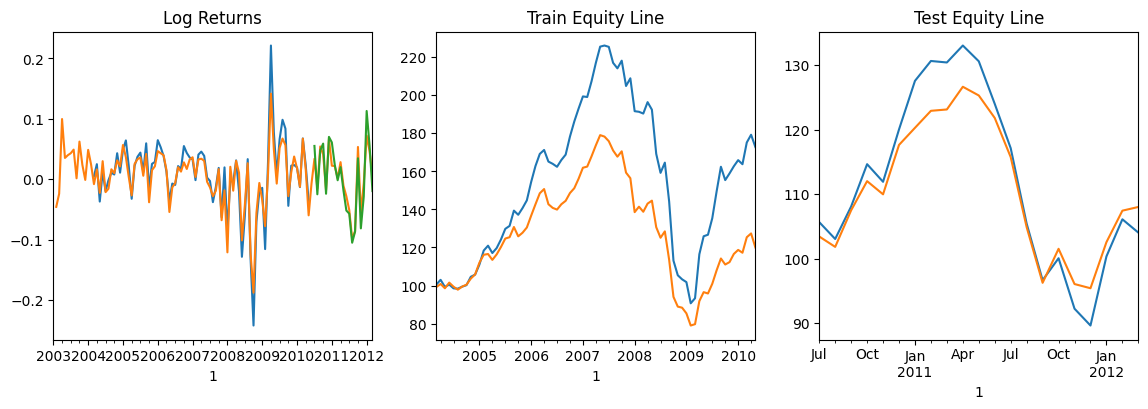

In [244]:
import matplotlib.pyplot as plt

fig, ax = plt.subplots(1,3, figsize=(14,4))

# BCHMK
bch_train_ret = np.exp(bch.loc[dl_train_returns.index])
bch_test_ret = np.exp(bch.loc[dl_test_returns.index])

bch_train_eqty_line = 100 * np.cumprod(bch_train_ret)
bch_test_eqty_line = 100 * np.cumprod(bch_test_ret)

# TRAIN
train_ret = np.exp(dl_train_returns)
train_eqty_line = 100 * np.cumprod(train_ret)

# TEST
test_ret = np.exp(dl_test_returns)
test_eqty_line = 100 * np.cumprod(test_ret)

# Log Returns
dl_train_returns.plot(ax=ax[0])
bch.plot(ax=ax[0])
dl_test_returns.plot(ax=ax[0])

# Train eqty line
train_eqty_line.plot(ax=ax[1])
bch_train_eqty_line.plot(ax=ax[1])

# Test eqty line
test_eqty_line.plot(ax=ax[2])
bch_test_eqty_line.plot(ax=ax[2])

ax[0].set_title('Log Returns')
ax[1].set_title('Train Equity Line')
ax[2].set_title('Test Equity Line')

Holding period: 1 -- IR: 0.911
Holding period: 2 -- IR: 1.237
Holding period: 3 -- IR: 0.534
Holding period: 4 -- IR: 0.924
Holding period: 5 -- IR: 1.345
Holding period: 6 -- IR: 1.015


<Axes: >

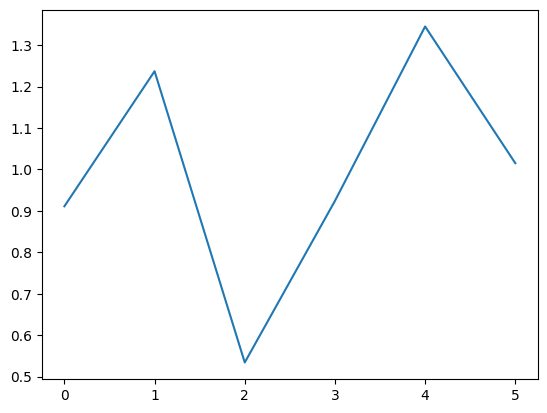

In [285]:
univ_holding_cv(train_scores, 6, 1, how='long', ptf_size=200).plot()

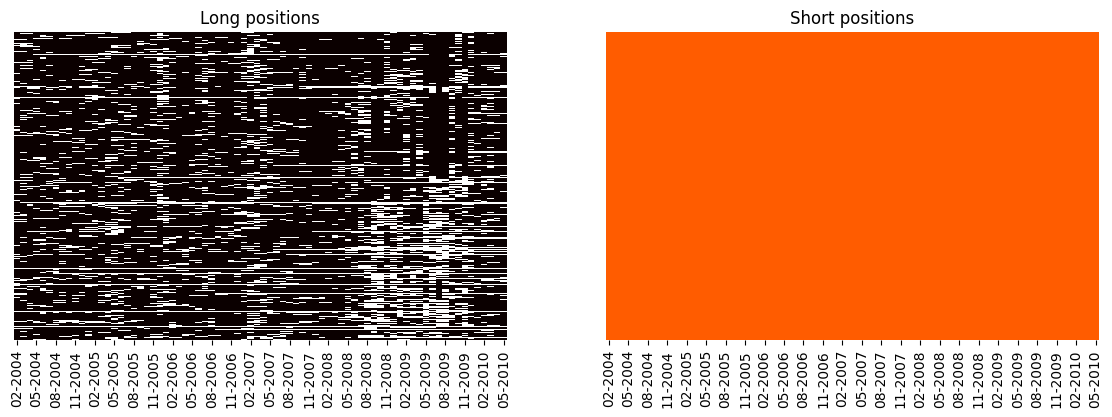

In [ ]:
plot_positions(train_scores, train_hlong, train_hshort)

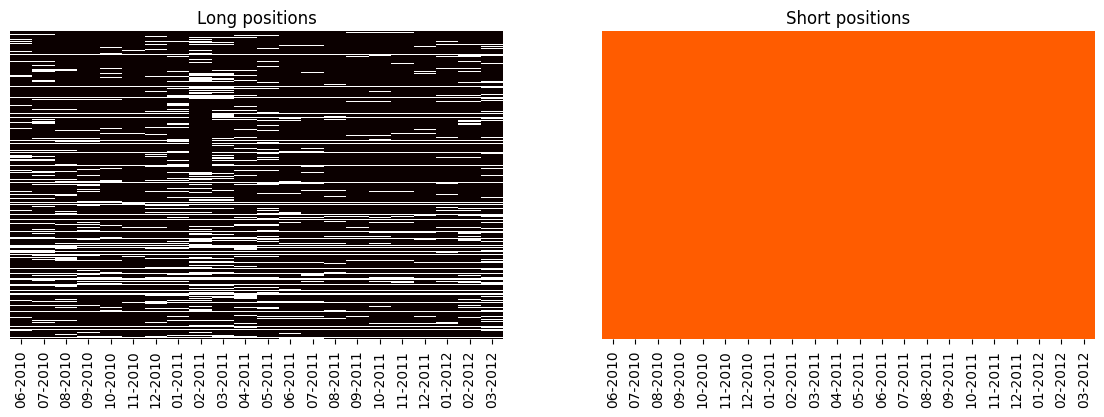

In [ ]:
plot_positions(test_scores, test_hlong, test_hshort)